# Notebook to make a cow' breed classification for classes: Angus, Hereford and no pure breed

Comamand to execute a local instance of jupyter notebooks so it can be used with colab

In [7]:
pip install tensorflow

In [8]:
pip install tensorflowjs

In [9]:
!pip install patool

In [10]:
!pip install pyunpack

Imports

In [11]:
import tensorflow as tf  #version 2.10.0
import keras
import numpy as np
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import os
from pyunpack import Archive

In [12]:
Archive('rawDataset.rar').extractall('')

Constants

In [13]:
height=224
width=224
img_dim_target=(height, width, 3)
root='/content/'  #change it to the directory you'll use to store images
post_dir=root+'rawDataset/'
batch_size=32
files_to_predict=root+'to_predict/'

Importing data to the model  (it is using 60% images for training, 20% for validating and 20% for testing )

Check that there isn't more folders than three named as classes

In [18]:
training_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=['Angus','Hereford','NoBreed'],
    subset='training',
    seed=123
)
validation_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=['Angus','Hereford','NoBreed'],
    subset='validation',
    seed=1234
)

#test_data is to keep some untrained fresh data to test the model
validation_data, test_data = tf.keras.utils.split_dataset (validation_data, 0.5, 0.5, shuffle=True, seed=12345)

Found 512 files belonging to 3 classes.
Using 308 files for training.
Found 512 files belonging to 3 classes.
Using 204 files for validation.


Plot some training data

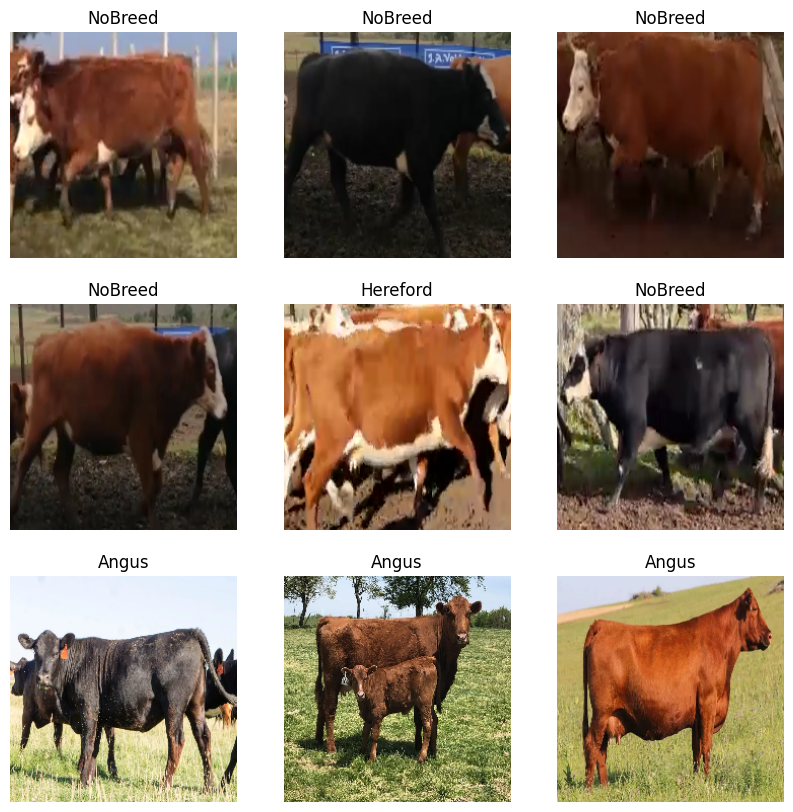

In [19]:
classes = training_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")

Data augmenter function

In [20]:
#it there is overfit try with different data augmentation
def data_augmenter():
  y=data_augmenter=tf.keras.Sequential()
  data_augmenter.add(layers.RandomFlip("horizontal"))
  data_augmenter.add(layers.RandomRotation((-0.06, 0.06)))
  return data_augmenter

Callback

SACAR LA DATA AUGMENTATION DEL MODELO Y USARLA SOLO PARA EL TRAINING SET

Defining the Neural Network architecture with transfer learning (MobileNetV2)

Instanciate model (do not worry about warnings)

In [21]:
def first_model(image_shape=img_dim_target, data_augmentation=data_augmenter()):

  #setting the model which will be used to transfer its learning
  base_model=tf.keras.applications.MobileNetV2(input_shape=img_dim_target,
                                             include_top=False,
                                             weights='imagenet'
                                             )
  base_model.trainable= False

  inputs= tf.keras.Input(shape=image_shape)
  x=data_augmentation(inputs)
  x=tf.keras.applications.mobilenet_v2.preprocess_input(x)
  x=base_model(x, training=False)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [22]:
class Callback1(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy')> 0.99:
      print("\n Model has reached 99% accuracy")
      self.model.stop_training= True

In [23]:
callback=Callback1()

model=first_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

history=model.fit(training_data, validation_data=validation_data,epochs=15, callbacks=[callback])

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/15
10/10 [==============================] - 16s 267ms/step - loss: 1.0043 - accuracy: 0.5714 - val_loss: 0.7163 - val_accuracy: 0.7157
Epoch 2/15
10/10 [==============================] - 3s 83ms/step - loss: 0.5731 - accuracy: 0.7760 - val_loss: 0.4597 - val_accuracy: 0.8627
Epoch 3/15
10/10 [==============================] - 3s 99ms/step - loss: 0.3759 - accuracy: 0.8604 - val_loss: 0.3614 - val_accuracy: 0.8922
Epoch 4/15
10/10 [==============================] - 7s 125ms/step - loss: 0.3220 - accuracy: 0.8831 - val_loss: 0.3250 - val_accuracy: 0.8922
Epoch 5/15
10/10 [==============================] - 4s 86ms/step - loss: 0.2713 - accuracy: 0.9188 - val_loss: 0.2857 - val_accuracy: 0.8922
Epoch 6/15
10/10 [==============================] - 5s 108ms/step - loss: 0.2515 - accuracy: 0.9026 - val_loss: 0.2702 - val_accuracy: 0.9118
Epoch 7/15
10/10 [==============================] - 4s 81ms/step - loss: 0.2334 - accur

Improve the model by training some previous layers

In [24]:
for layer in model.layers[len(model.layers)-10:]:
  layer.trainable=True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine=model.fit(training_data,validation_data=validation_data,epochs=30, initial_epoch=history.epoch[-1], callbacks=[callback])

Epoch 15/30
10/10 [==============================] - 8s 243ms/step - loss: 0.1181 - accuracy: 0.9708 - val_loss: 0.1551 - val_accuracy: 0.9412
Epoch 16/30
10/10 [==============================] - 3s 83ms/step - loss: 0.1086 - accuracy: 0.9610 - val_loss: 0.1404 - val_accuracy: 0.9510
Epoch 17/30
10/10 [==============================] - 3s 80ms/step - loss: 0.1001 - accuracy: 0.9578 - val_loss: 0.1353 - val_accuracy: 0.9412
Epoch 18/30
10/10 [==============================] - 6s 116ms/step - loss: 0.1030 - accuracy: 0.9513 - val_loss: 0.1230 - val_accuracy: 0.9706
Epoch 19/30
10/10 [==============================] - 3s 83ms/step - loss: 0.1014 - accuracy: 0.9643 - val_loss: 0.1169 - val_accuracy: 0.9706
Epoch 20/30
10/10 [==============================] - 3s 81ms/step - loss: 0.0772 - accuracy: 0.9838 - val_loss: 0.1162 - val_accuracy: 0.9706
Epoch 21/30
10/10 [==============================] - 5s 112ms/step - loss: 0.0763 - accuracy: 0.9773 - val_loss: 0.1126 - val_accuracy: 0.9706
Epo

In [25]:
import time

saved_model_path= "./{}.h5".format(int(time.time()))
model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-08-20 20:51:19.187579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [27]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/  \
    /content/

2023-08-20 20:51:23.287024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 962, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 948, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 618, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 79, in di

Test accuracy in the test set

In [28]:
predictions=model.evaluate(test_data)

4/4 [==============================] - 0s 45ms/step - loss: 0.0498 - accuracy: 1.0000


Test your own images

In [29]:
to_predict=os.listdir(files_to_predict)
model= tf.keras.models.load_model(root+ 'models')
class_names=['Angus','Hereford','NoBreed']

FileNotFoundError: ignored

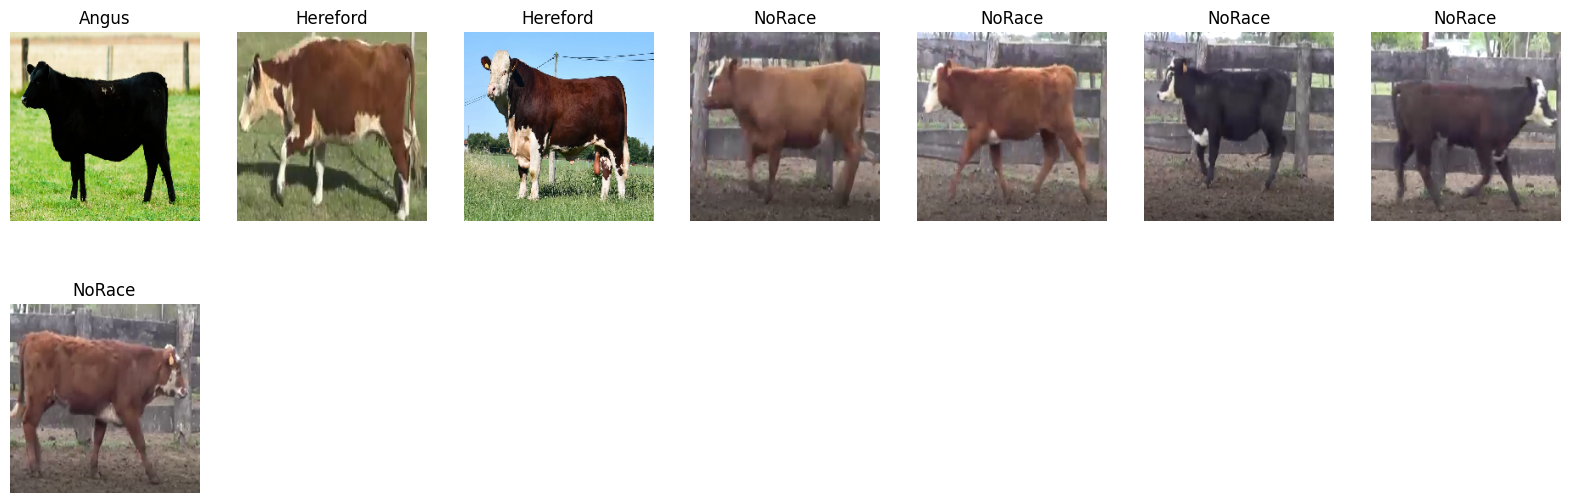

In [ ]:
counter=0
plt.figure(figsize=(20, 10))
rows=  np.ceil(len(to_predict)/7)

for fn in to_predict:
  path= files_to_predict +str(fn)

  image=  tf.keras.utils.load_img(path, target_size=(height,width))
  x =  tf.keras.utils.img_to_array(image)
  x = np.expand_dims(x, axis=0)
  x = np.vstack([x])
  classes = model.predict(x, batch_size=1, verbose=0)

  preds_classes = np.argmax(classes, axis=-1)

  ax = plt.subplot(3, 7, counter + 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(class_names[preds_classes[0]])

  counter+=1

Things to improve:

* Make a cell applying data augmentation in training to see it in action
* Make a cell to see the process of convolutions through examples
* It could be trained with only two classes instead of three as it actually is because it is only important to know whether a cow is pure breed or not and it may achieve a better performance.

Limitations:

* Right now the model is only able to clasify a cow per picture and it also has to be horizontally positioned in the frame.
* Because of the previous constraint predictions may not be accurate enough to detect imperfections of the cows' breed in a place that is not shown in the image.

All this limitations could be solved with more data.